# Transfer learning (domain adaptation)

Once the domain shift between phase 1 and phase 2 populations has been identified, let us jump to domain adaptation. Several techniques will be implemented:

1. Semi-supervised learning (use of the small subset of labelled data for learning)
2. Self-supervised learning (use features of the unlabelled data itself to learn from it. An example would be having labelled on certain records, masking these labels and then trying to learn them)
3. Unsupervised domain adaptation (align phase 1 and phase 2 distributions in a common latent space, where all the data of the target population is unlabelled)

(Some other approaches to face domain shift: 
- Domain Adversarial Training: Here, models are trained to have representations which cannot be easily distinguished between source and target using a domain discriminator.
- Subspace Alignment: Methods like CORrelation ALignment (CORAL) minimize domain shift by aligning the second-order statistics (covariance) of source and target features.
- Instance Re-weighting: Source instances are re-weighted based on their similarity to the target domain.
- Fine-tuning: After pre-training a model on the source domain, it is fine-tuned on a small labeled dataset from the target domain.)

In [165]:
import os
import numpy as np
import pandas as pd
import importlib
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score, precision_score, recall_score
import prince

# import from custom package
from auxFuns.EDA import *
from auxFuns.modelling import *
from auxFuns.class_overlap import *
from auxFuns.transfer_learning import *

In [164]:
import auxFuns.EDA 
importlib.reload(auxFuns.EDA)

import auxFuns.modelling
importlib.reload(auxFuns.modelling)

import auxFuns.class_overlap
importlib.reload(auxFuns.class_overlap)

import auxFuns.transfer_learning
importlib.reload(auxFuns.transfer_learning)

<module 'auxFuns.transfer_learning' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\transfer_learning.py'>

## Loading of data and dataframes preparation

In [5]:
# Load of the data and filter in the needed features

raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

# Phase 1 data
rsv_predictors_df_v2 = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup_seasons_prevTest_v2.csv',low_memory=False)
rsv_predictors_phase1_df = make_it_categorical_v2(rsv_predictors_df_v2)

# Phase 2 data
rsv_phase2_df = pd.read_csv(processed_datasets_path + '/rsv_phase2_all_features.csv',low_memory=False)
rsv_phase2_df = make_it_categorical_v2(rsv_phase2_df, is_phase1 = False)

# Small subset of labelled data of phase 2:
labels_phase2_df = pd.read_csv(raw_datasets_path + '/rsv_test_phase2.csv',low_memory=False)
labels_phase2_df = labels_phase2_df.rename(columns = {'RSV_test_date':'index_date'})

# Compatibility issue detected: merging labelled and unlabelled data is challening due to incompatible date columns
rsv_phase2_df.index_date = pd.to_datetime(rsv_phase2_df.index_date)
labels_phase2_df.index_date = pd.to_datetime(labels_phase2_df.index_date)

rsv_phase2_labelled_df = labels_phase2_df.merge(rsv_phase2_df, how='left', on=['patient_id', 'index_date'])
# rsv_phase2_labelled_df = labels_phase2_df.merge(rsv_phase2_df, how='left', on=['patient_id'])
rsv_phase2_labelled_df = rsv_phase2_labelled_df.dropna()

rsv_predictors_phase1_df.shape, rsv_phase2_df.shape, rsv_phase2_labelled_df.shape

((86058, 64), (291938, 63), (2867, 64))

In [6]:
# Only 2003 of the 3073 (~65%) patients who underwent a RSV test are present in the whole populations's dataset
patient_ids_rsv_test = labels_phase2_df.patient_id.unique()
patient_ids_phase2 = rsv_phase2_df.patient_id.unique()

len(patient_ids_rsv_test), len(patient_ids_phase2), (pd.Series(patient_ids_rsv_test).isin(patient_ids_phase2)).sum()

(3073, 40507, 2003)

In [7]:
selected_features = ['sex', 'marital_status', 'race','patient_regional_location', 'age_group',
                     'Acute_upper_respiratory_infection','Influenza','Pneumonia','Bronchitis','Symptoms_and_signs__digestive_system_and_abdomen','General_symptoms_and_signs','any_symptom',
                     'COPD','AIDS','Asthma_chronic','CCI',
                     'sine','cosine','calendar_year', 
                     'healthcare_seeking', 'influenza_vaccine',
                     'n_symptoms','prev_positive_rsv','previous_test_daydiff','n_immunodeficiencies', 
                     'tumor_indicator','tumor_last_year',
                     'season',
                     'n_tests_that_day']
selected_features_v1 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'season','multiple_tests']
selected_features_v2 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'key_comorbidities','Pneumonia',
                     'season','month_of_the_test','multiple_tests',
                     'BPA','BPAI']
selected_features_v3 = selected_features_v2 + ['race', 'age_group','marital_status','sex',
                                                    'patient_regional_location','calendar_year']

selected_features_v2_aux = selected_features_v2.copy()
selected_features_v1.append('RSV_test_result')
selected_features_v2.append('RSV_test_result')
selected_features_v3.append('RSV_test_result')

In [8]:
df_modelling_phase1 = rsv_predictors_phase1_df[selected_features_v2]
df_modelling_phase2 = rsv_phase2_labelled_df[selected_features_v2]
df_modelling_all_phase2 = rsv_phase2_df[selected_features_v2_aux]

df_modelling_phase1.shape, df_modelling_phase2.shape, df_modelling_all_phase2.shape

((86058, 21), (2867, 21), (291938, 20))

In [9]:
# differentiate between labelled and non-labelled data in phase 2
labelled_data_phase2_mask = rsv_phase2_labelled_df.index
labelled_mask = rsv_phase2_df.index.isin(labelled_data_phase2_mask)
non_labelled_mask = ~rsv_phase2_df.index.isin(labelled_data_phase2_mask)

df_modelling_phase2_labelled = df_modelling_phase2.copy()
df_modelling_phase2_nonlabelled = df_modelling_all_phase2.loc[non_labelled_mask,:]

df_modelling_phase1.shape, df_modelling_phase2_labelled.shape, df_modelling_phase2_nonlabelled.shape

((86058, 21), (2867, 21), (289071, 20))

In [10]:
# Ensure consistency between source and target categories
df_modelling_phase2_labelled_copy = df_modelling_phase2_labelled.copy()
df_modelling_phase2_nonlabelled_copy = df_modelling_phase2_nonlabelled.copy()

df_modelling_phase2_labelled['n_tests_that_day'] = pd.Categorical(df_modelling_phase2_labelled_copy['n_tests_that_day'], categories=[1, 2])
df_modelling_phase2_nonlabelled['n_tests_that_day'] = pd.Categorical(df_modelling_phase2_nonlabelled_copy['n_tests_that_day'], categories=[1, 2])

C:\Users\angel\AppData\Local\Temp\ipykernel_20908\1378035625.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelling_phase2_nonlabelled['n_tests_that_day'] = pd.Categorical(df_modelling_phase2_nonlabelled_copy['n_tests_that_day'], categories=[1, 2])


## 1. Semi-supervised domain adaptation

Let us start by using the small subset of labelled data of phase 2. To this end, we will evaluate the following methods:

- Re weighting of key samples
- Alignment of the latent spaces
- Domain-adversarial training
 

In [12]:
df_modelling_phase2_labelled.RSV_test_result.value_counts(), 

positives_phase2 = df_modelling_phase2_labelled.RSV_test_result.value_counts()[1]
negatives_phase2 = df_modelling_phase2_labelled.RSV_test_result.value_counts()[0]
p_pos_phase2 = positives_phase2/(positives_phase2+negatives_phase2)
IR_phase2 = negatives_phase2/positives_phase2

print(f'Number of positive samples in labelled data phase 2: {positives_phase2}')
print(f'Proportion of positive labels: {p_pos_phase2}')
print(f'Imbalance ratio of phase 2 labelled data: {IR_phase2}')
# the imbalance in this case is even heavier than in phase 1 data

Number of positive samples in labelled data phase 2: 52
Proportion of positive labels: 0.018137425880711544
Imbalance ratio of phase 2 labelled data: 54.13461538461539


In [13]:
X_source = df_modelling_phase1.drop(['RSV_test_result'], axis = 1)
labels_source = df_modelling_phase1['RSV_test_result']

X_target = df_modelling_phase2_labelled.drop(['RSV_test_result'], axis = 1)
labels_target = df_modelling_phase2_labelled['RSV_test_result']

# Define the combined population too
X_combined = pd.concat([X_source, X_target], axis = 0)
y_combined = np.hstack((np.zeros(len(X_source)), np.ones(len(X_target))))

np.unique(y_combined, return_counts = True)

(array([0., 1.]), array([86058,  2867], dtype=int64))

In [274]:
# Visualize the small labelled set of phase 2
# Also, visualize how the labelled data is overlapped or not
random_seed = 42
n_components = 5

famd = prince.FAMD(n_components=n_components, random_state=random_seed)
famd = famd.fit(X_target)

df_labelled_phase2_visualization = famd.transform(X_target)

# Add the phase label for visualization
df_labelled_phase2_visualization['RSV_test_result'] = labels_source

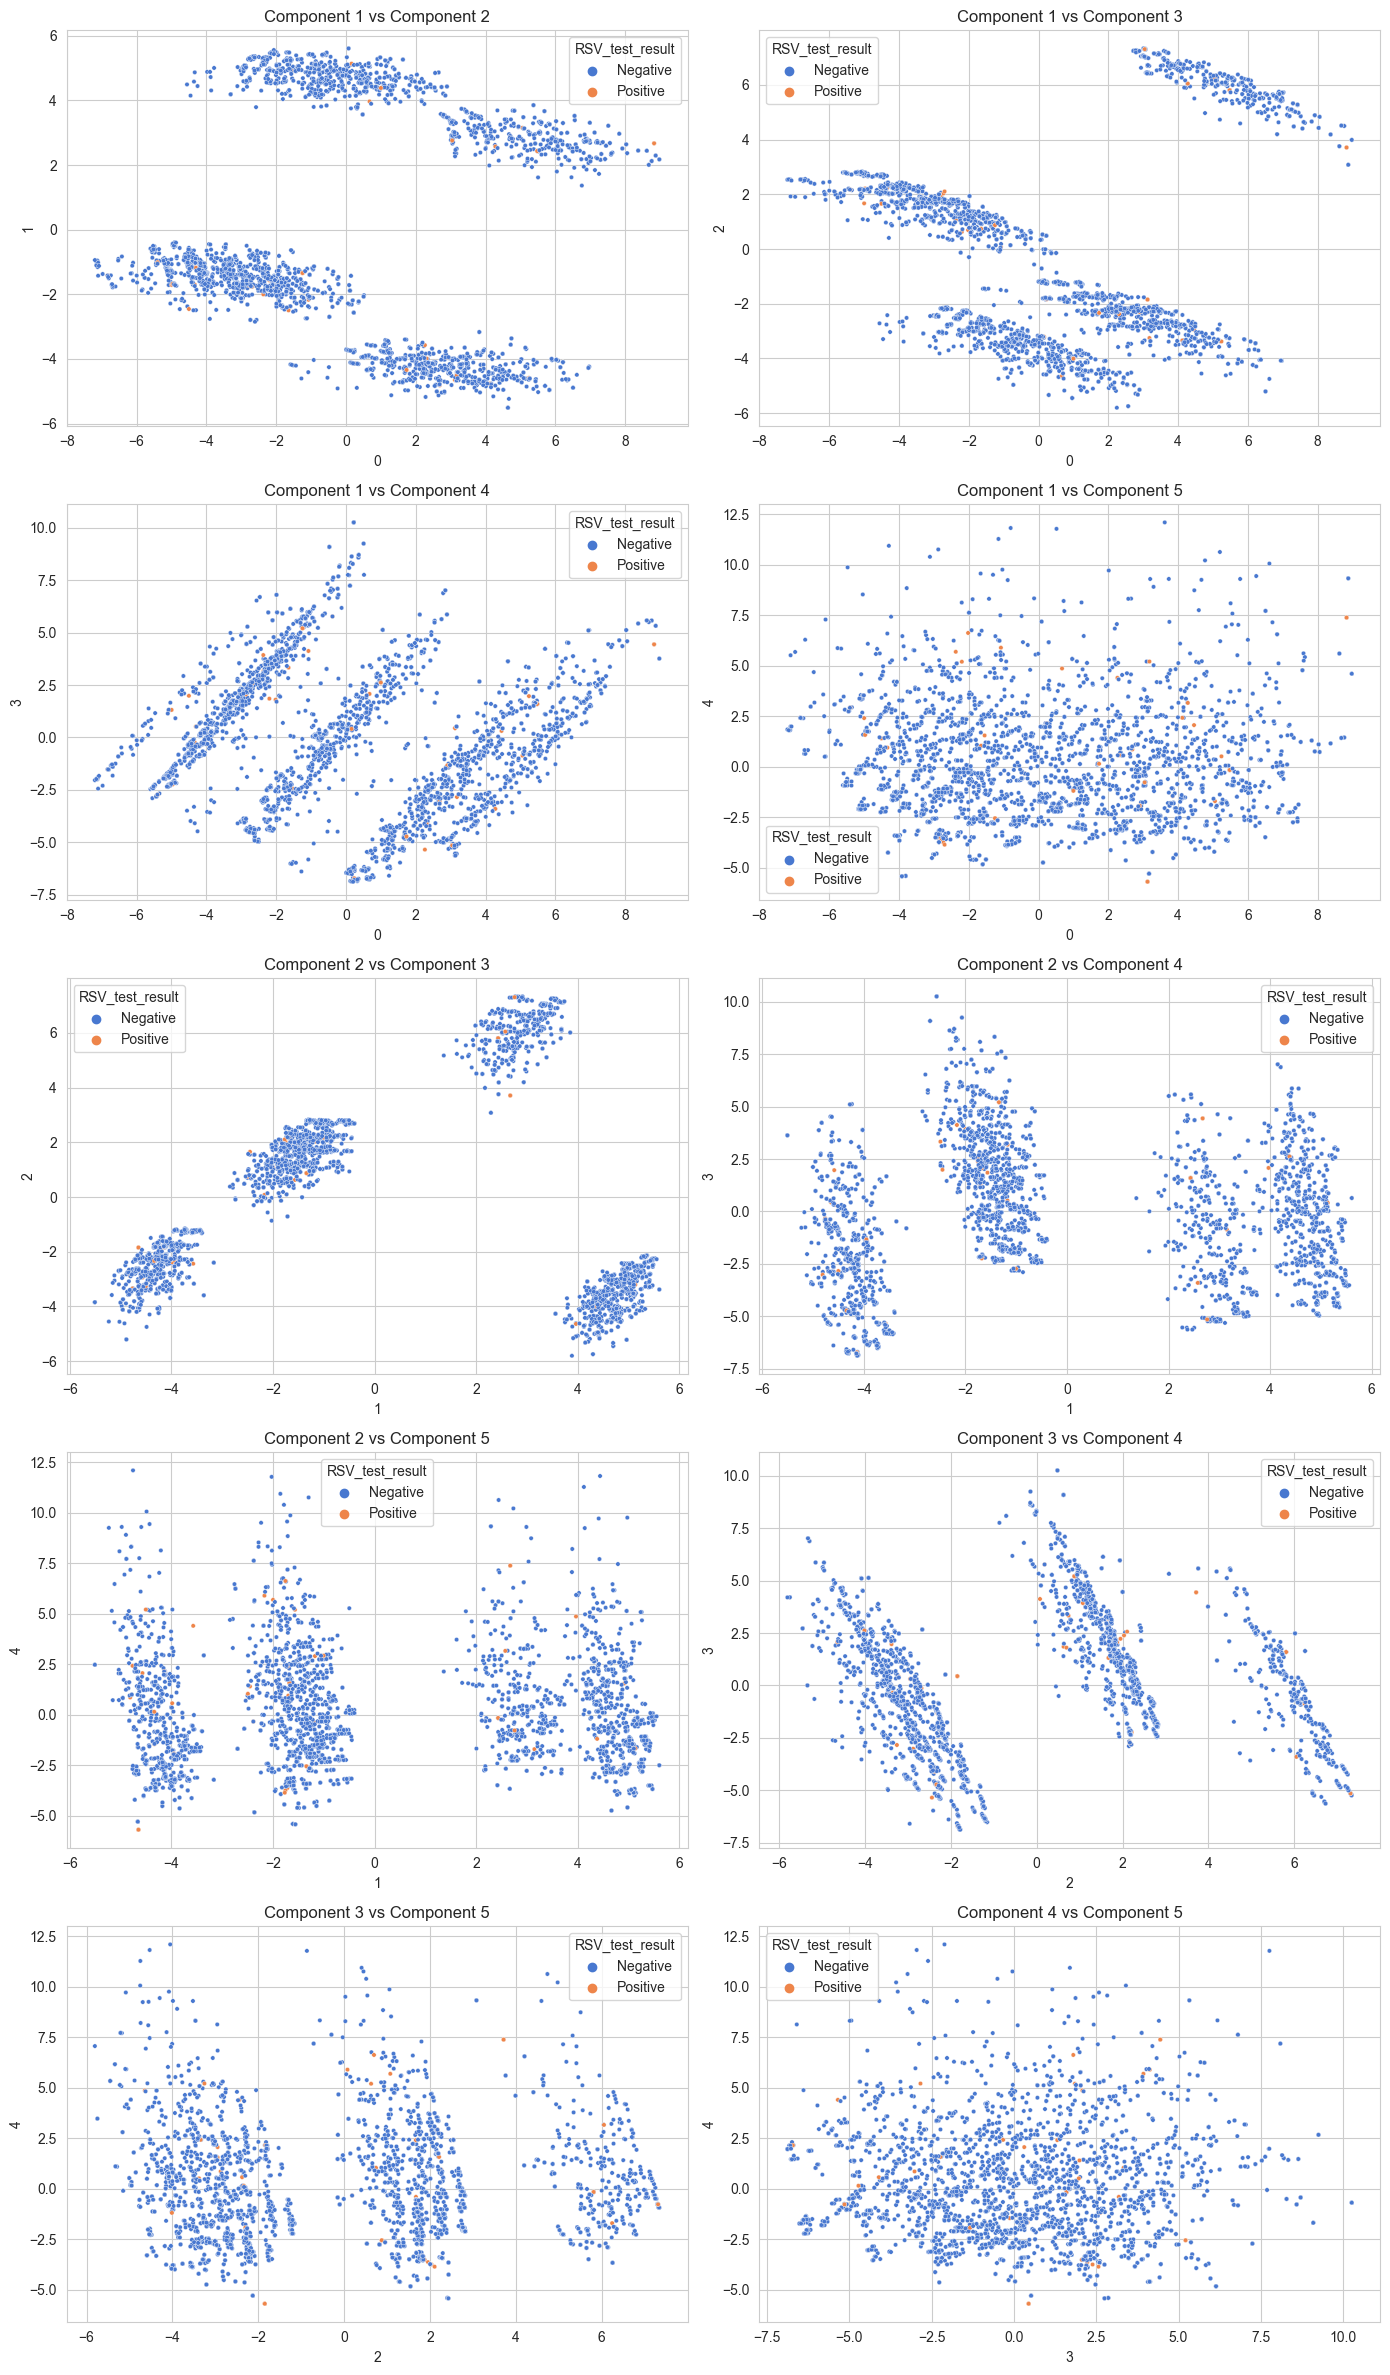

In [272]:
plot_5FMDA_planes(df = df_labelled_phase2_visualization, hue_target = 'RSV_test_result',s_size = 10)

In [147]:
# Also, visualize how the labelled data is overlapped or not
random_seed = 42
n_components = 5

famd = prince.FAMD(n_components=n_components, random_state=random_seed)
famd = famd.fit(X_combined)

df_labelled_data_visualization = famd.transform(X_combined)

# Add the phase label for visualization
df_labelled_data_visualization['labelled_phase'] = y_combined

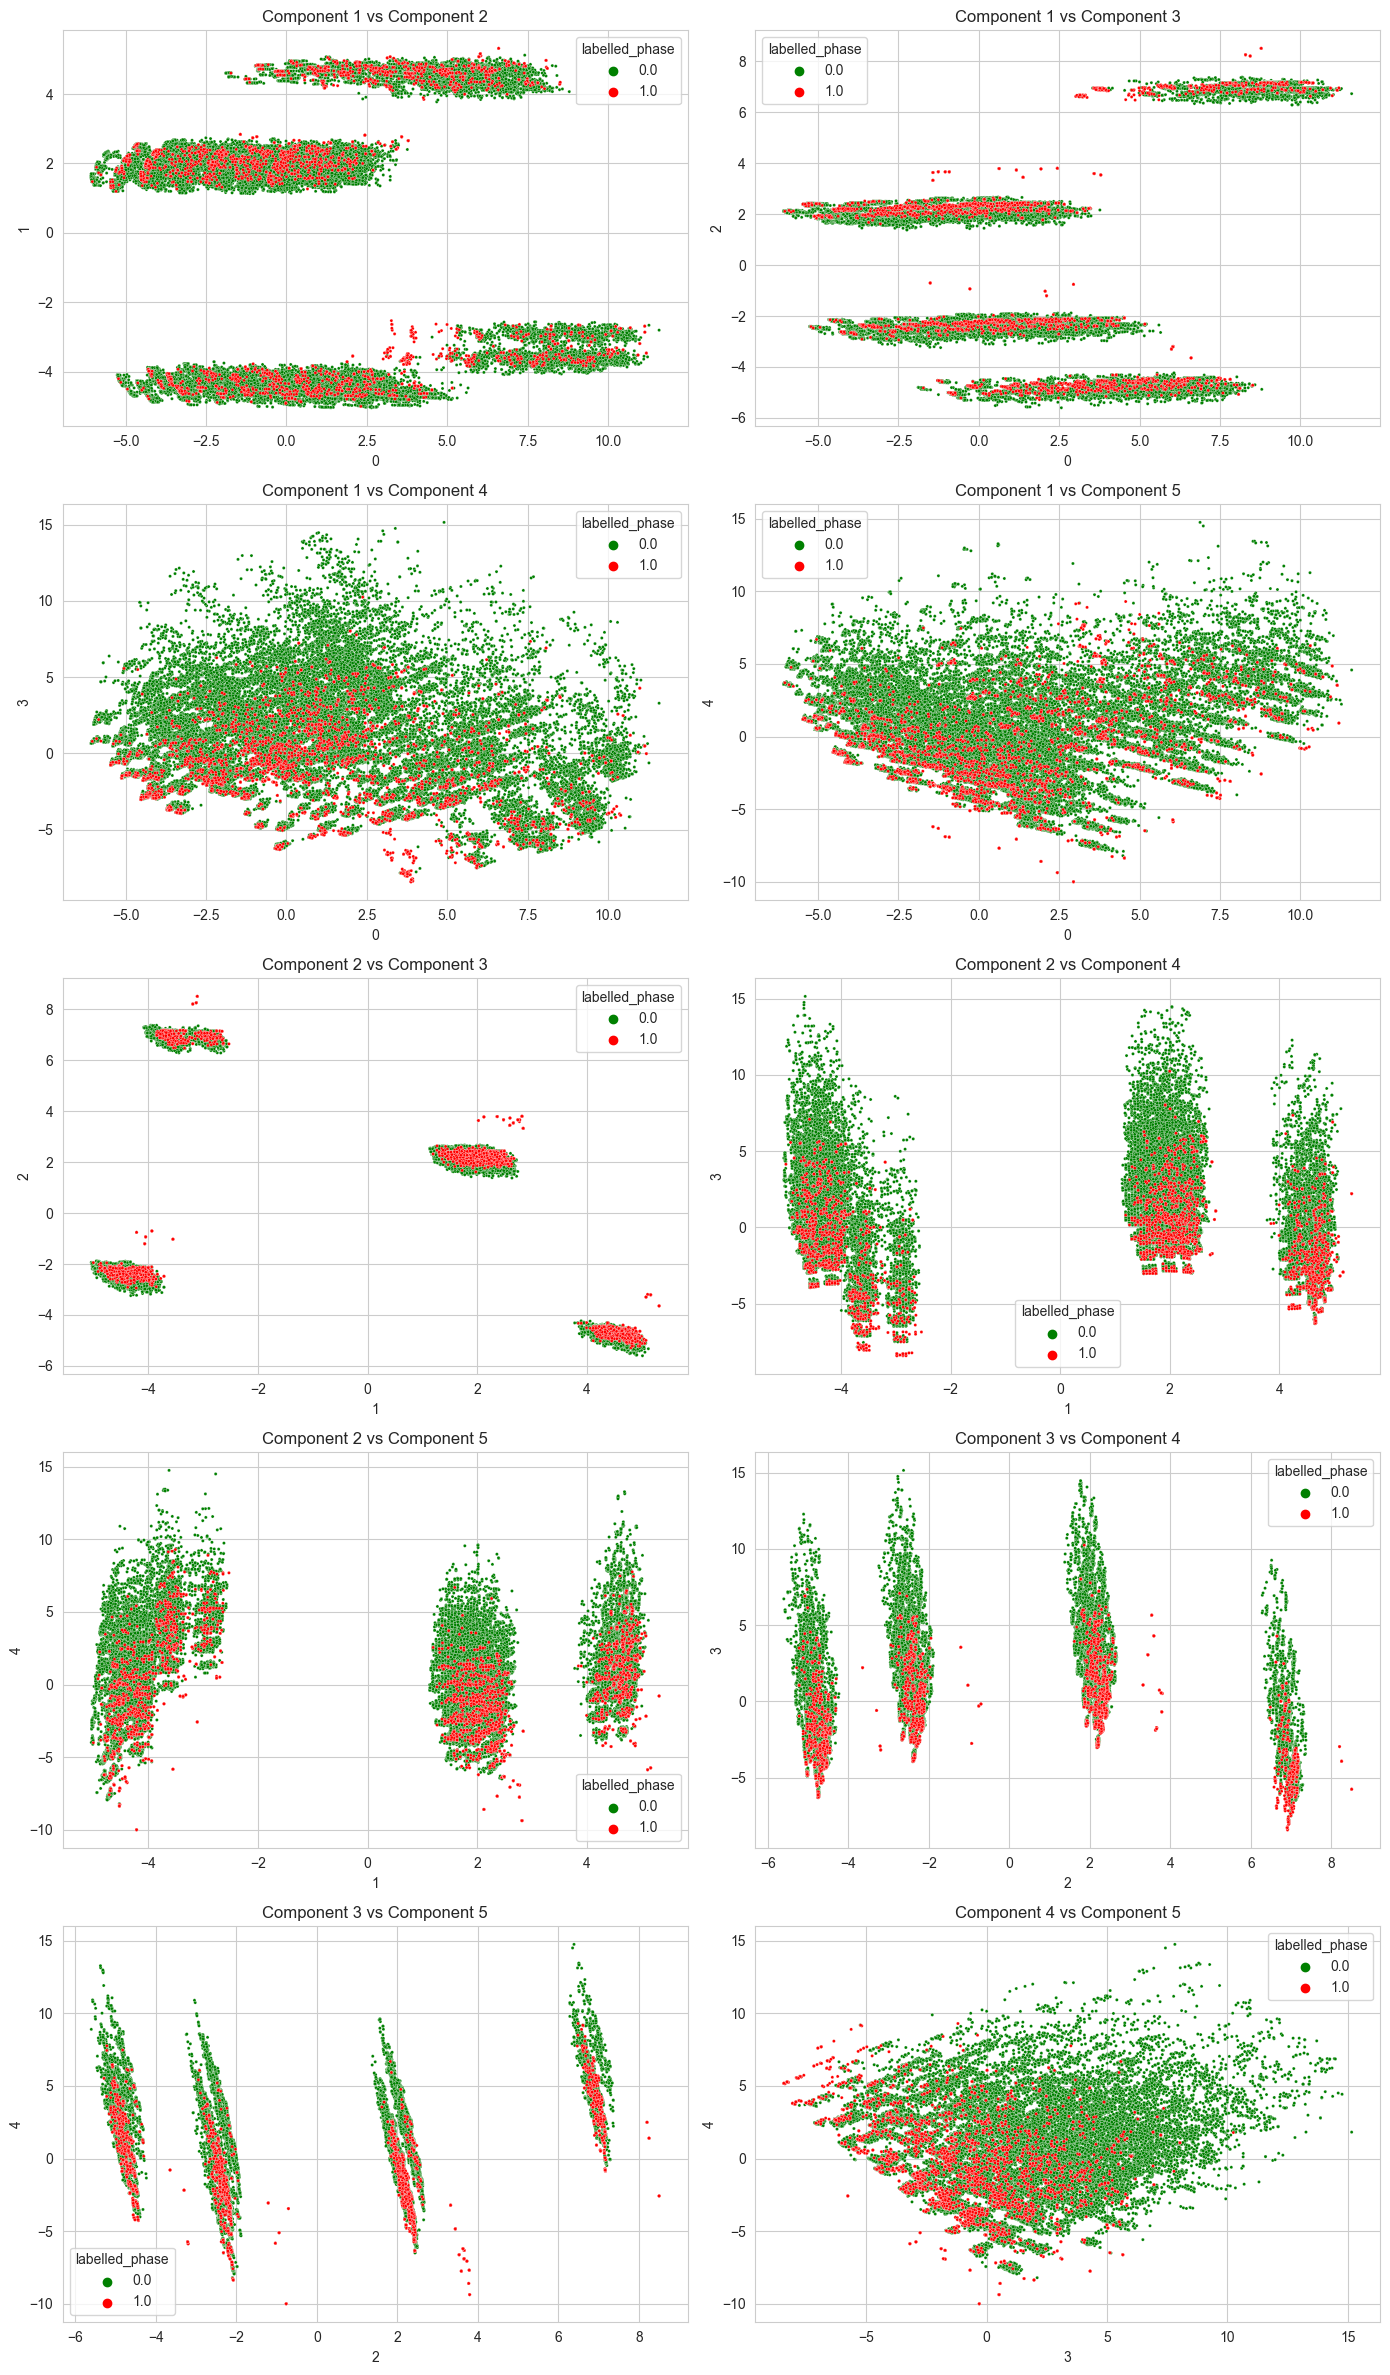

In [148]:
plot_5FMDA_planes(df = df_labelled_data_visualization, hue_target = 'labelled_phase', palette = {1: 'red', 0:'green'},s_size = 5)

These results are interesting as enable to differentiate between two clear areas of points in the source population:
- Some are clearly overlapped with phase 2 data
- Some are clearly separated

This will allow a more eficient weighting of the source instances

### Semi-supervised: instance-reweighting

Instance reweighting by itself can be challenging. We will follow the approach of using a discriminator to differentiate between phase 1 and phase 2 labelled data, and then use the prediction probabilities of that discriminator as weights.
1. Build a discriminator and compute the same-weights that will affect training of the model in phase 1 (output: source_instances_weights)
2. Train the model in phase 1 taking this source_instances_weights as sample weights in the model
3. Evaluate the retrained model in target data

In [186]:
# 1. Build the discriminator and compute the source_instance_weights
# i) build a classifier able to differentiate between phase 1 and phase 2 data
# ii) on the same set as the training, predict the probabilities to belonging to one or the other 
# iii) assign these probabilities as weights for the instance re-weighting process

# i: train a discriminator (and see its performance)
# all the followuing hyperparameters are introduced so the random forest is not too good at memorizing the training data
discriminator = RandomForestClassifier(n_estimators=15, 
                                       max_depth=10, 
                                       min_samples_split=10, 
                                       min_samples_leaf=5, 
                                       max_features=0.5, 
                                       oob_score=True,
                                       class_weight = {0:1, 1:15}).fit(pd.get_dummies(X_combined), y_combined)
print("OOB Score:", discriminator.oob_score_)

# discriminator = LogisticRegression().fit(pd.get_dummies(X_combined), y_combined)

# Predict for all instances (X_combined) to evaluate performance
probs_performance = discriminator.predict_proba(pd.get_dummies(X_combined))[:, 1] # Probabilities for class 1 (being part of target population)
y_pred_performance = probs_performance > 0.5
accuracy_discriminator = accuracy_score(y_combined, y_pred_performance)
recall_discriminator = recall_score(y_combined, y_pred_performance)
precision_discriminator = precision_score(y_combined, y_pred_performance)

print(f'Accuracy of the discriminator is: {accuracy_discriminator}')
print(f'Recall of the discriminator is: {recall_discriminator}')
print(f'Precision of the discriminator is: {precision_discriminator}')

# ii: predict the probabilities (for source data only, as we are interested in reweighting the instances of the source population)
probs_source = discriminator.predict_proba(pd.get_dummies(X_source))[:, 1] # Probabilities for class 1 (being part of target population)
probs_target = discriminator.predict_proba(pd.get_dummies(X_target))[:, 1]

# iii: define the weights for instance reweighting
source_instances_weights = probs_source / (1 - probs_source)
target_instances_weights = probs_target / (1.01 - probs_target)

C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


OOB Score: 0.9679167838065785
Accuracy of the discriminator is: 0.9727073376440821
Recall of the discriminator is: 0.6616672479944192
Precision of the discriminator is: 0.5655933214072749


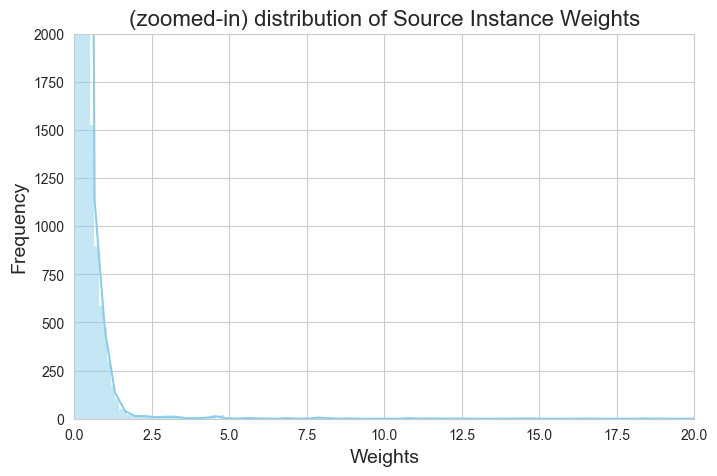

In [180]:
# Histogram for visualization of the final weights
weights = source_instances_weights[source_instances_weights >= 0]

sns.set_style("whitegrid")
sns.set_palette("muted")

plt.figure(figsize=(8,5))
sns.histplot(weights, bins=200, kde=True, color='skyblue')

plt.title('(zoomed-in) distribution of Source Instance Weights', fontsize=16)
plt.xlabel('Weights', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim([0,20]); plt.ylim([0,2000])
plt.show()

In [161]:
# 2. Re-train phase 1 model with the determined weights (source_instance_weights)
n_neighbours_to_determine_overlap = 4

# Determine the overlapping and non-overlapping onstances in source
X_source_dummies = pd.get_dummies(X_source)
y_source = labels_source.copy()
same_class_neighbours_dict_source, __, __, __ = calculate_same_neighbours_and_N1(X = X_source_dummies, y = y_source, n_neighbours = 5)


Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.0480606102860861
N1 metric for 2 neighbours : 0.07181203374468381
N1 metric for 3 neighbours : 0.09376234632457181
N1 metric for 4 neighbours : 0.11344674521834108
Done!


In [248]:
# Train the overlapping and non-overlapping models in phase 1 (source) data. Add the source_instance weights identified previously
print('\n------------------')
print('-------------------')
print('Fitting model on trainig data exclusively')
print(f'Building the two models using as reference {n_neighbours_to_determine_overlap} number of neighbours to determine overlap')
# Let us also add the source_instances_weights as feature for the model:

X_source_positivity = X_source.copy()
X_source_positivity['domain_likeliness_to_phase2'] = source_instances_weights

source_instances_weights_non_overlapping = source_instances_weights[same_class_neighbours_dict_source[n_neighbours_to_determine_overlap] == True]
source_instances_weights_overlapping = source_instances_weights[same_class_neighbours_dict_source[n_neighbours_to_determine_overlap] == False]


model_nonOverlapping, model_Overlapping = only_build_2overlapping_models(X = X_source_positivity, labels = y_source, same_class_neighbors = same_class_neighbours_dict_source[n_neighbours_to_determine_overlap], 
                                                                        random_seed = 42,
                                                                        model_class_non_overlapping = RandomForestClassifier(),
                                                                        param_grid_non_overlapping = {'n_estimators': [7, 14],'max_depth': [10, 20],'min_samples_split': [5, 10],'min_samples_leaf': [1, 4]},
                                                                        cost_sensitive_non_overlapping = False, weight_dict_non_overlapping = {'Negative': 1, 'Positive': 5},
                                                                        model_class_overlapping = RandomForestClassifier(),
                                                                        param_grid_overlapping = {'n_estimators': [7, 14],'max_depth': [10, 20],'min_samples_split': [5, 10],'min_samples_leaf': [1, 4]},
                                                                        cost_sensitive_overlapping = False, weight_dict_overlapping = {'Negative': 1, 'Positive': 5},
                                                                        sample_weights_Overlapping = source_instances_weights_overlapping, sample_weights_nonOverlapping = source_instances_weights_non_overlapping)


------------------
-------------------
Fitting model on trainig data exclusively
Building the two models using as reference 4 number of neighbours to determine overlap
----------------
Building non-overlapping model ...
Training model ... RandomForestClassifier(class_weight={'Negative': 200, 'Positive': 1},
                       random_state=42)
Best training parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 7}
Best training f1-score:  0.3906542056074766
----------------
Building (yes) overlapping model ...
Training model ... RandomForestClassifier(random_state=42)
Best training parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 7}
Best training f1-score:  0.09606657095810162


In [249]:
# 3. Evaluate the model in phase 2 labelled data
# 3.1. Take same_class_neighbours as hidden
X_target_positivity = X_target.copy()
X_target_positivity['domain_likeliness_to_phase2'] = target_instances_weights

X_target_dummies =  pd.get_dummies(X_target_positivity)
y_target = labels_target

preds_proba_nonOverlapping = model_nonOverlapping.predict_proba(X_target_dummies)[:,1]
preds_proba_Overlapping = model_Overlapping.predict_proba(X_target_dummies)[:,1]

soft_vote_weight_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 5, 7, 10, 15, 20, 25, 30]
best_threshold_overlapping = None
best_performance_metric = float('-inf')

for soft_vote_weight in soft_vote_weight_values:
        
    y_probs = (1/(soft_vote_weight + 1)) * (preds_proba_nonOverlapping + soft_vote_weight*preds_proba_Overlapping)

    optimal_thr_aggregated = find_optimal_moving_threshold_from_probas(y_probs = y_probs, y_test = y_target, verbose = False)

    __, prec, recall, __, __, __, f1, __ = calculate_performance_metrics_from_probas(y_probs = y_probs, y_test = y_target, threshold = optimal_thr_aggregated, print_roc = False, print_pr = False, verbose=False)

    if f1 > best_performance_metric:
        best_performance_metric = f1
        best_imbratio = soft_vote_weight
        best_recall = recall
        best_prec = prec

print("Best soft vote weight:", best_imbratio)
print("Best performance metric (f1) for RSV-positivity model:", best_performance_metric)     
print("Associated recall:", best_recall)        
print("Associated precision:", best_prec)  

Best soft vote weight: 0.7
Best performance metric (f1) for RSV-positivity model: 0.04187725631768953
Associated recall: 0.5576923076923077
Associated precision: 0.02175543885971493


In [252]:
# 3.2 Take same_class_neighbours as known for phase 2 labelled data

same_class_dict_target, __, __, __ = calculate_same_neighbours_and_N1(X = X_target_dummies, y = y_target, n_neighbours = 5)

true_overlapping_mask = ~same_class_dict_target[1]

y_probs_all = (true_overlapping_mask * preds_proba_Overlapping) + ((~true_overlapping_mask) * preds_proba_nonOverlapping)

optimal_threshold = find_optimal_moving_threshold_from_probas(y_probs=y_probs_all, y_test=y_target, verbose = True)

__, __, __, __, __, __, f1, __ = calculate_performance_metrics_from_probas(y_probs = y_probs_all, y_test = y_target, 
                                                                    threshold= optimal_threshold, print_roc = False, print_pr = False, verbose = True)

Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.032089291942797304
N1 metric for 2 neighbours : 0.044645971398674544
N1 metric for 3 neighbours : 0.062434600627834014
N1 metric for 4 neighbours : 0.07952563655388911
Done!
Optimal threshold: 0.86
Optimal f1: 0.02061855670103093


AUC Score: 0.27092498975269846
Precision / Positive predictive value: 0.014084507042253521
Specificity: 0.9502664298401421
Recall / sensitivity: 0.038461538461538464
Negative predictive value: 0.981651376146789
Accuracy: 0.9337286362050924
F-1: 0.02061855670103093
Precision-Recall AUC: 0.030266107288318078


Same problem as when non-source instances weighting is present: the model is **too biased towards positive samples**. The recall numbers are good but precision needs to be improved

### Semi-supervised: label shift mitigation

In this section we will implement the RLLS method [5], which specificly tackles domain shift. The steps to take are:

1. Dataset Split: Divide source dataset into training and validation sets. Training set to train the initial model and the validation set to **estimate the importance weights**.

2. Train an Initial Model: Train a classifier on the source training set. This classifier will serve as an initial model to which we will apply the RLLS corrections.

3. Estimate Source Label Distribution, in this case 3.0% positive and 97.0% negative.

4. Estimate Target Label Distribution: 1.8% positive and 98.2% negative.

5. Compute Importance Weights: Using the above distributions, compute the importance weights for each class, as indicated in the paper

6. Apply Importance Weights on Validation Set. 
​
7. Retrain or Adjust Classifier with Weight 

8. Evaluate on Target Data: Once the model has been adjusted for the label shift, evaluate its performance on the target dataset to determine how well it generalizes.

9. Regularization: sample-size-dependent regularization


[5] Azizzadenesheli, K., Liu, A., Yang, F., & Anandkumar, A. (2019). Regularized learning for domain adaptation under label shifts. arXiv preprint arXiv:1903.09734.


In [ ]:
# Short version of this: 

# Train the overlapping and non-overlapping models in phase 1 (source) data. Add the source_instance weights identified previously
print('\n------------------')
print('-------------------')
print('Fitting model on trainig data exclusively')
print(f'Building the two models using as reference {n_neighbours_to_determine_overlap} number of neighbours to determine overlap')
# Let us also add the source_instances_weights as feature for the model:

aux_same_class_neighbours = np.array([True]*X_source.shape[0])

model_nonOverlapping, model_Overlapping = only_build_2overlapping_models(X = X_source, labels = y_source, same_class_neighbors = aux_same_class_neighbours, 
                                                                        random_seed = 42,
                                                                        model_class_non_overlapping = RandomForestClassifier(),
                                                                        param_grid_non_overlapping = {'n_estimators': [7, 14],'max_depth': [10, 20],'min_samples_split': [5, 10],'min_samples_leaf': [1, 4]},
                                                                        cost_sensitive_non_overlapping = True, weight_dict_non_overlapping = {'Negative': 5, 'Positive': 1},
                                                                        )

In [264]:
# 3.2 Take same_class_neighbours as known for phase 2 labelled data
X_target_dummies =  pd.get_dummies(X_target)
y_target = labels_target

preds_proba_nonOverlapping = model_nonOverlapping.predict_proba(X_target_dummies)[:,1]
y_probs = preds_proba_nonOverlapping
optimal_threshold = find_optimal_moving_threshold_from_probas(y_probs=y_probs, y_test=y_target, verbose = True)

__, __, __, __, __, __, f1, __ = calculate_performance_metrics_from_probas(y_probs = y_probs, y_test = y_target, 
                                                                    threshold= optimal_threshold, print_roc = False, print_pr = False, verbose = True)

Optimal threshold: 0.01
Optimal f1: 0.04


AUC Score: 0.5166586965432436
Precision / Positive predictive value: 0.020801232665639446
Specificity: 0.5484902309058615
Recall / sensitivity: 0.5192307692307693
Negative predictive value: 0.9840662842574889
Accuracy: 0.5479595395884199
F-1: 0.04
Precision-Recall AUC: 0.06528370943084441


### Semi-supervised learning: fit a completely new model to phase 2 labelled data


In [289]:
X_target_dummies = pd.get_dummies(X_target)
same_class_dict_target, __, __, __ = calculate_same_neighbours_and_N1(X = X_target_dummies, y = y_target, n_neighbours = 5)

n_neighbours_to_model = 1

df_aux = pd.concat([X_target_dummies, y_target], axis = 1)
model_nonOverlapping_phase2, model_Overlapping_phase2 = build_and_evaluate_2overlapping_models(df1 = df_aux, same_class_neighbors = same_class_dict_target[n_neighbours_to_model], 
                                                                                   cost_sensitive_overlapping = False, cost_sensitive_non_overlapping = False)


Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...


Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.03174049529124523
N1 metric for 2 neighbours : 0.049180327868852514
N1 metric for 3 neighbours : 0.06313219393093827
N1 metric for 4 neighbours : 0.08022322985699337
Done!
----------------
Building non-overlapping model ...
Training model ... RandomForestClassifier(random_state=42)
Best training parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 7}
Best training f1-score:  0.26666666666666666

----------------
Performance metrics of non-overlapping model ...
Optimal threshold: 0.12
Optimal f1: 1.0


AUC Score: 1.0
Precision / Positive predictive value: 1.0
Specificity: 1.0
Recall / sensitivity: 1.0
Negative predictive value: 1.0
Accuracy: 1.0
F-1: 1.0
Precision-Recall AUC: 1.0
----------------
Building (yes) overlapping model ...
Training model ... RandomForestClassifier(random_state=42)
Best training parameters:  {'max_depth': 10, 'min_samples_leaf': 4, '

c:\Users\angel\Documents\VSCode\rsv_modelling_transfer_learning\auxFuns\modelling.py:639: RuntimeWarning: invalid value encountered in longlong_scalars
  npv = tn / (tn + fn)


### Semi-supervised learning: alignment in a latent space and fit of a model

1. Alignment in a latent space (in the famd-5 component space)
2. Determination of overlapping vs non-overlapping instances
3. Training of a model in that latent space of the target and source domains (with label shift, i.e. add the importance weights)
4. Evaluation on target population

This approach relies on three key steps:
1. Feature engineering: removing three features that did not make sense to be used on the target population (mathematically speaking, those with a higher covariate shift) - deals with **covariate shift**
2. Data pre-processing: alignment of the two source and target populations in a common, shared latent space - deals with **covariate shift**
3. Model-level: implementation of new class-weights following the label shift approach - deals with **label shift**

In [146]:
# Some features used on the source domain (all patients with RSV test) may not make sense in the target domain (patients with symptoms, not necessarily RSV tests)
rsv_test_related_features = ['n_tests_that_day', 'previous_test_daydiff', 'multiple_tests']

X_target = X_target.drop(rsv_test_related_features, axis = 1)
X_source = X_source.drop(rsv_test_related_features, axis = 1)

X_target.shape, X_source.shape, labels_target.value_counts(), labels_source.value_counts()


((2867, 17),
 (86058, 17),
 Negative    2815
 Positive      52
 Name: RSV_test_result, dtype: int64,
 Negative    83404
 Positive     2654
 Name: RSV_test_result, dtype: int64)

In [147]:
X_target.shape, X_source.shape, labels_target.value_counts(), labels_source.value_counts()

X_combined = pd.concat([X_source, X_target], axis = 0)
y_combined = pd.concat([labels_source, labels_target], axis = 0)
X_combined.shape, y_combined.value_counts()

((88925, 17),
 Negative    86219
 Positive     2706
 Name: RSV_test_result, dtype: int64)

In [179]:
# 1. Alignment in the latent space
random_seed = 42
n_components = 3

famd = prince.FAMD(n_components=n_components, random_state=random_seed)
famd = famd.fit(X_combined)

X_combined_famd5 = famd.transform(X_combined)

# Build the source and target dataframes in the aligned target space
X_source_famd5 = X_combined_famd5.iloc[:X_source.shape[0]]
X_target_famd5 = X_combined_famd5.iloc[-X_target.shape[0]:]

In [162]:
# Compute the Wasserstein-like distance before and after alignment
X_source_dummies = pd.get_dummies(X_source)
X_target_dummies = pd.get_dummies(X_target)
distance_before = wasserstein_balltree(X_source_dummies, X_target_dummies)
distance_after = wasserstein_balltree(X_source_famd5, X_target_famd5)

print(f"Wasserstein-like distance before alignment: {distance_before}")
print(f"Wasserstein-like distance after alignment: {distance_after}")


Wasserstein-like distance before alignment: 0.930411165203219
Wasserstein-like distance after alignment: 0.2231123212678203
The alignment improved the closeness of the source and target domains!


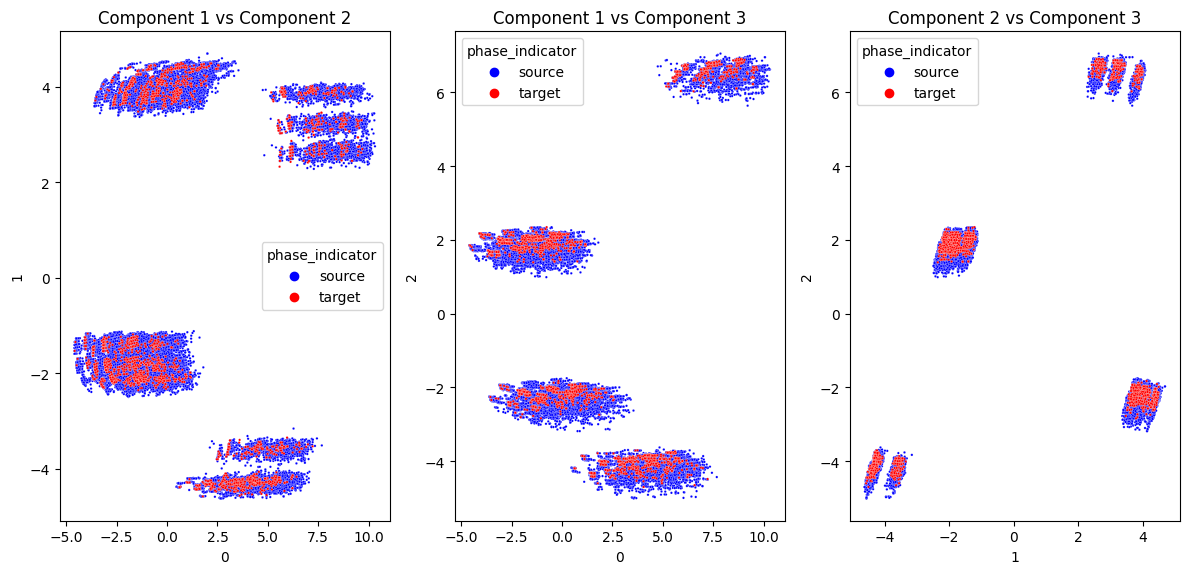

In [180]:
# Plot of the target-source alignment
phase_indicator = pd.DataFrame(['source']*(X_source.shape[0]) +  ['target']*(X_target.shape[0]), columns = ['phase_indicator'])
df_visualization_X_combined  = pd.concat([X_combined_famd5.reset_index(drop = True), phase_indicator], axis = 1)

plot_3FMDA_planes(df = df_visualization_X_combined, hue_target = 'phase_indicator',s_size = 3, palette = {'source': 'blue', 'target':'red'})

Analyzing feature: 0


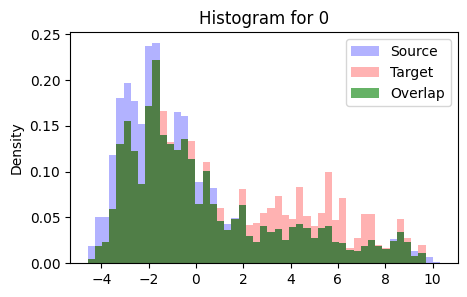

Overlap area: 0.8301244349421695
KS Statistic: 0.14617196748977535, P-value: 3.27683257750527e-52
KL Divergence: 0.12179730270073717
Histogram Intersection: 2.802966000609598


Analyzing feature: 1


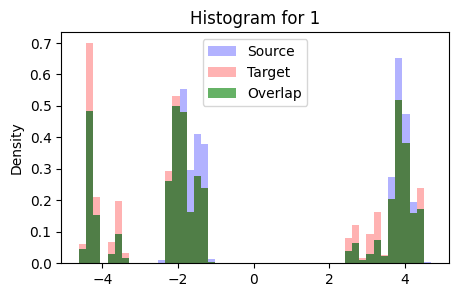

Overlap area: 0.8414116085579258
KS Statistic: 0.10634374528099305, P-value: 8.809583706325798e-28
KL Divergence: 0.09678988756590728
Histogram Intersection: 4.470611934560425


Analyzing feature: 2


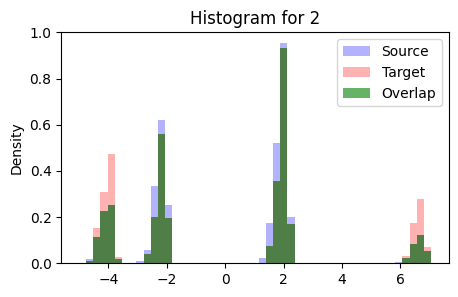

Overlap area: 0.845686659534448
KS Statistic: 0.08950023265674534, P-value: 8.602162236791758e-20
KL Divergence: 0.14268967956198775
Histogram Intersection: 3.415202130873059




In [181]:
# Mathematically check the alignment between both:
list_of_features = list(X_source_famd5.columns)
list_of_categorical_flags = list((X_source_famd5.dtypes) == 'category')

for feature, is_categorical in zip(list_of_features, list_of_categorical_flags):
    analyze_feature(X_source_famd5, X_target_famd5, feature, categorical=is_categorical)

Seems like source and target are mostly well aligned

source_Negative    83404
target_Negative     2815
source_Positive     2654
target_Positive       52
Name: phase_result, dtype: int64


c:\Users\angel\Documents\VSCode\rsv_modelling_transfer_learning\auxFuns\class_overlap.py:68: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


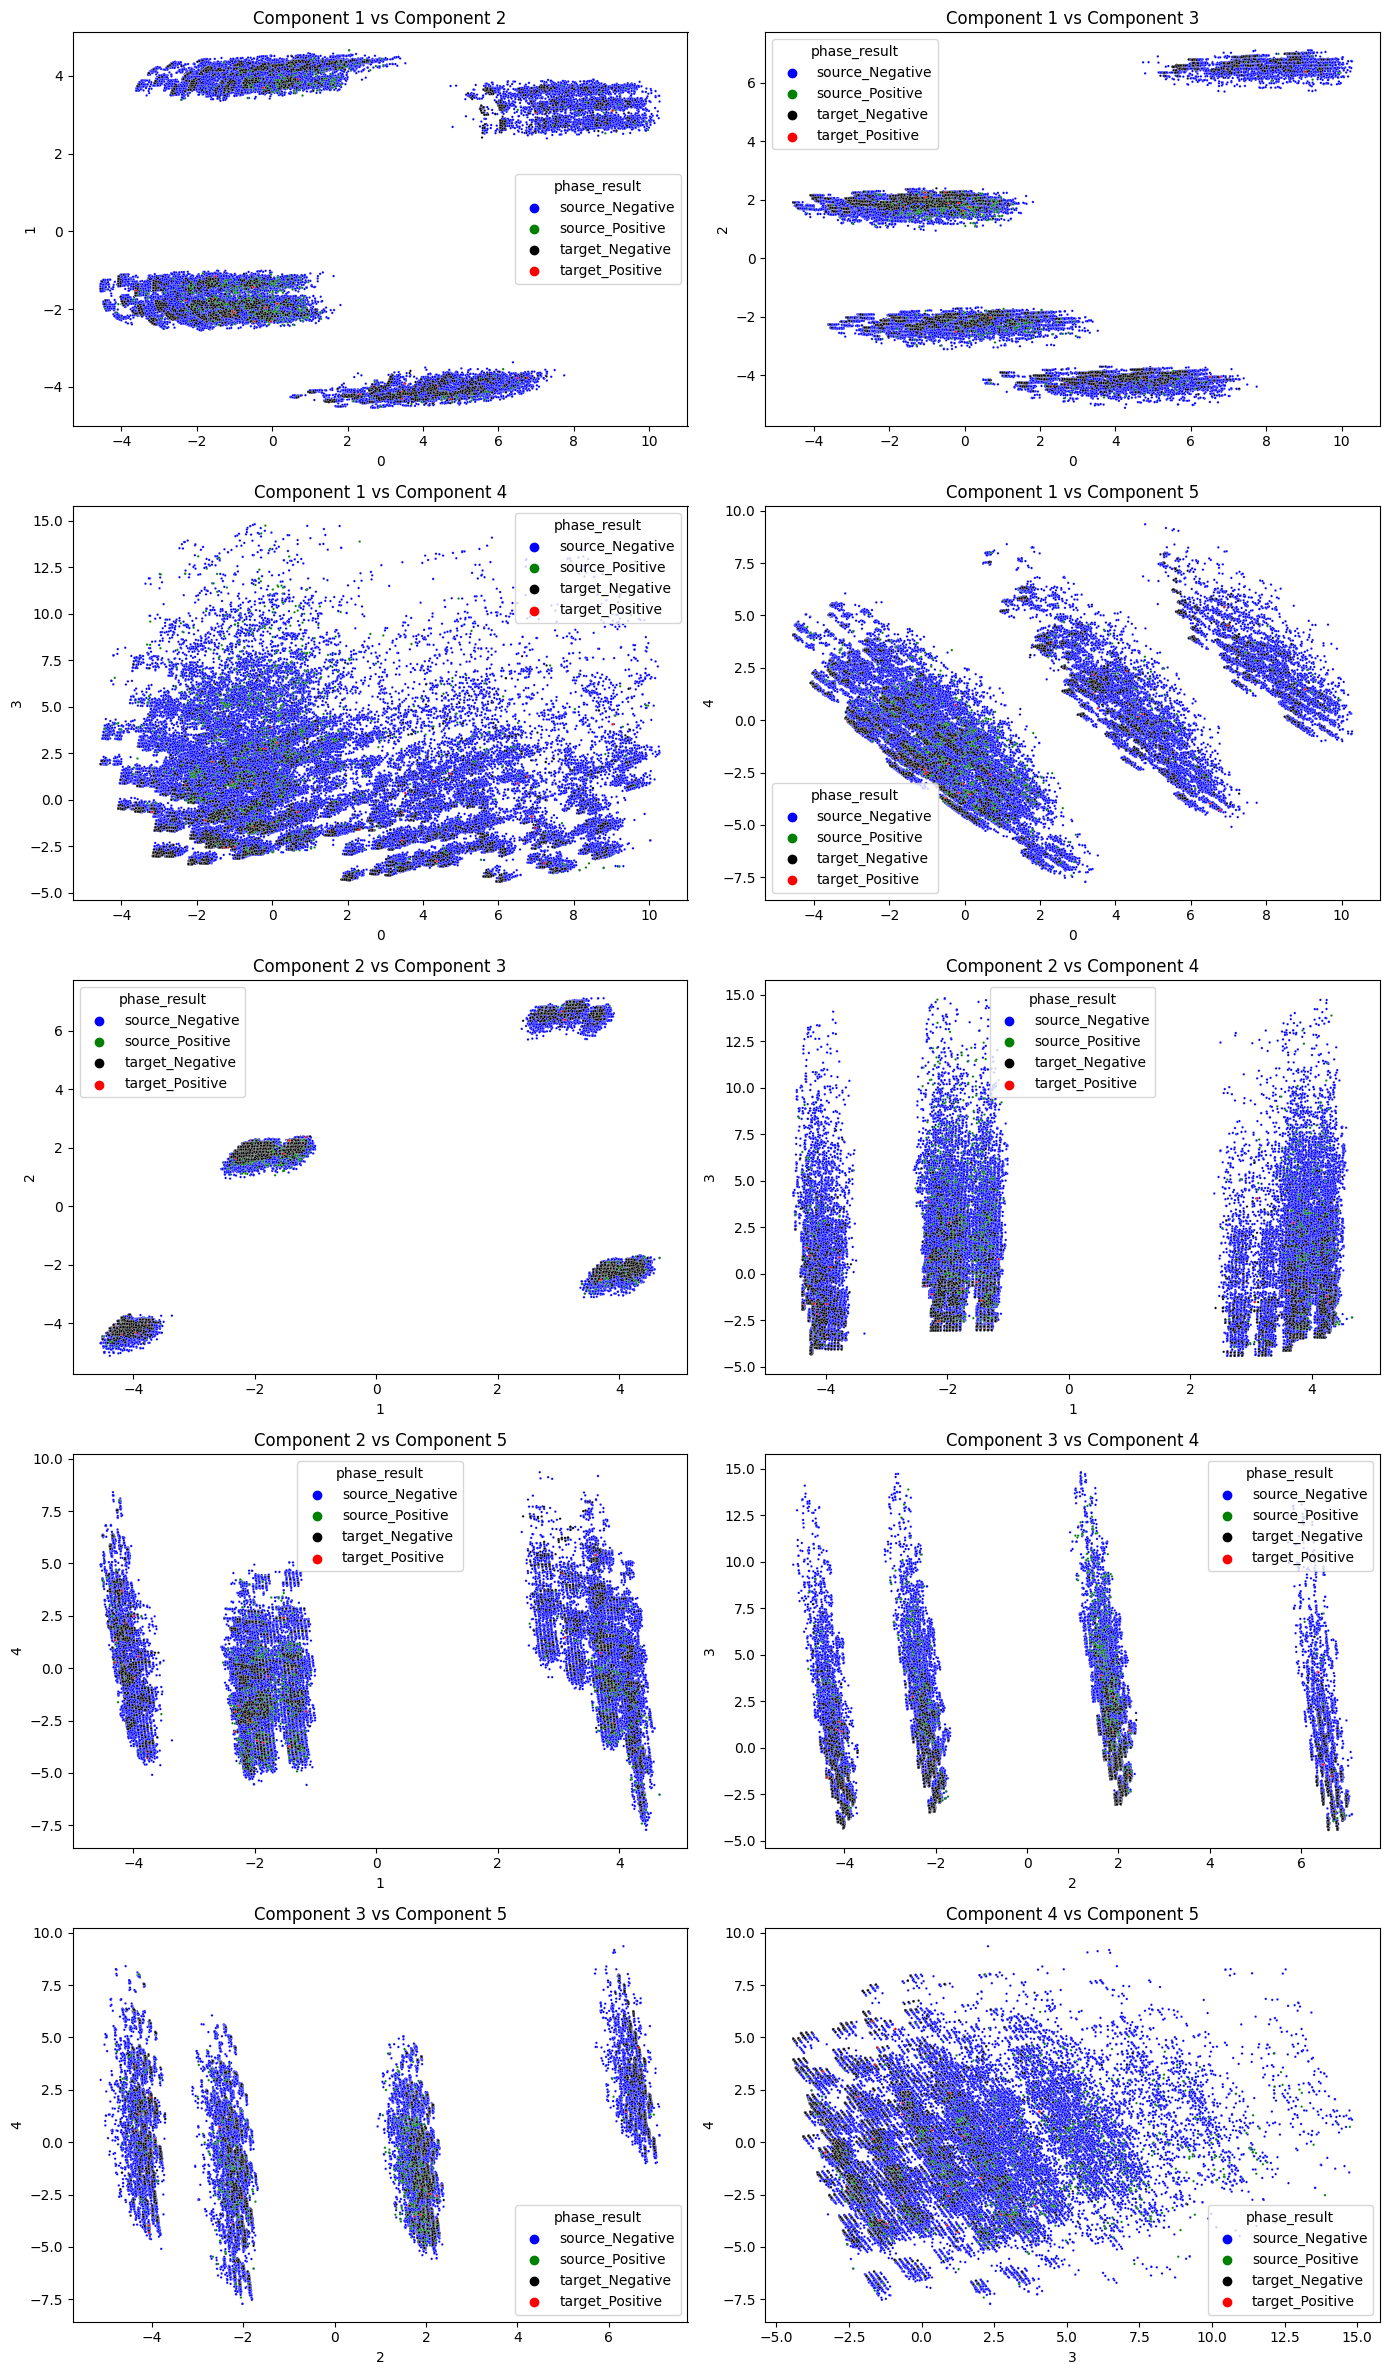

In [150]:
# Visualization now of positive and negative samples according to the two different samples
# It is important that the positive and negative classes are aligned in the two domains

aux = pd.concat([y_combined.reset_index(drop = True), phase_indicator], axis = 1)
aux['phase_result'] = aux.phase_indicator + '_' + aux.RSV_test_result
print(aux.phase_result.value_counts())

df_visualization_result_X_combined  = pd.concat([X_combined_famd5.reset_index(drop = True), aux['phase_result']], axis = 1)

plot_5FMDA_planes(df = df_visualization_result_X_combined, hue_target = 'phase_result',s_size = 3, palette = {'source_Negative': 'blue', 'source_Positive':'green', 'target_Negative':'black', 'target_Positive':'red'})

In [151]:
# 2. Determination of overlapping and non-overlapping regions in X_combined_famd5
## Taking the overlap of target + source together
# same_class_neighbours_X_combined, __, distance_matrix_y_combined, __ = calculate_same_neighbours_and_N1(X = X_combined_famd5, y = y_combined, n_neighbours = 5)

# len_source = X_source.shape[0]
# len_target = X_target.shape[0]
# same_class_neighbours_source = {key: value[:len_source] for key, value in same_class_neighbours_X_combined.items()}
# same_class_neighbours_target ={key: value[-len_target:] for key, value in same_class_neighbours_X_combined.items()}

## Taking the overlap of target + source separately
same_class_neighbours_source, __, distance_matrix_source, __ = calculate_same_neighbours_and_N1(X = X_source_famd5, y = labels_source, n_neighbours = 5)
same_class_neighbours_target, __, distance_matrix_target, __ = calculate_same_neighbours_and_N1(X = X_target_famd5, y = labels_target, n_neighbours = 5)


# Determination of the under-representation of 'Positives' in the target population
n_neighbours_to_determine_overlap = 1

N1_source = 1 - (same_class_neighbours_source[n_neighbours_to_determine_overlap]).sum() / len(same_class_neighbours_source[n_neighbours_to_determine_overlap])
N1_target = 1 - (same_class_neighbours_target[n_neighbours_to_determine_overlap]).sum() / len(same_class_neighbours_target[n_neighbours_to_determine_overlap])

print(f'\n--- Analysis taking {n_neighbours_to_determine_overlap} neighbours to determine overlap ---')
print(f'N1 metric in *source* population: {N1_source}')
print(f'N1 metric in *target* population: {N1_target}')

overlapping_labels_source = labels_source [same_class_neighbours_source[n_neighbours_to_determine_overlap] == False]
non_overlapping_labels_source = labels_source [same_class_neighbours_source[n_neighbours_to_determine_overlap] == True]

overlapping_labels_target = labels_target [same_class_neighbours_target[n_neighbours_to_determine_overlap] == False]
non_overlapping_labels_target = labels_target [same_class_neighbours_target[n_neighbours_to_determine_overlap] == True]

print('\n')
print(f'--- Value counts of overlapping areas: ---')
print(f'Source:\n{overlapping_labels_source.value_counts()}')
print(f'Target:\n{overlapping_labels_target.value_counts()}')
print(f'--- Value counts of nonoverlapping areas: ---')
print(f'Source:\n{non_overlapping_labels_source.value_counts()}')
print(f'Target:\n{non_overlapping_labels_target.value_counts()}')

# Computation of the importance weights for training of the model on phase 1 data
P_source_nonOverlapping_negative = non_overlapping_labels_source.value_counts()['Negative'] /(len(non_overlapping_labels_source))
P_source_nonOverlapping_positive =  non_overlapping_labels_source.value_counts()['Positive'] /(len(non_overlapping_labels_source))

P_source_Overlapping_negative = overlapping_labels_source.value_counts()['Negative'] /(len(overlapping_labels_source))
P_source_Overlapping_positive =  overlapping_labels_source.value_counts()['Positive'] /(len(overlapping_labels_source))

P_target_nonOverlapping_negative = non_overlapping_labels_target.value_counts()['Negative'] /(len(non_overlapping_labels_target))
P_target_nonOverlapping_positive =  non_overlapping_labels_target.value_counts()['Positive'] /(len(non_overlapping_labels_target))

P_target_Overlapping_negative = overlapping_labels_target.value_counts()['Negative'] /(len(overlapping_labels_target))
P_target_Overlapping_positive =  overlapping_labels_target.value_counts()['Positive'] /(len(overlapping_labels_target))

importance_weights_Overlapping_negative = P_target_Overlapping_negative / P_source_Overlapping_negative
importance_weights_Overlapping_positive = P_target_Overlapping_positive / P_source_Overlapping_positive
importance_weights_nonOverlapping_negative = P_target_nonOverlapping_negative / P_source_nonOverlapping_negative
importance_weights_nonOverlapping_positive = P_target_nonOverlapping_positive / P_source_nonOverlapping_positive

Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.05656650166166999
N1 metric for 2 neighbours : 0.08201445536731045
N1 metric for 3 neighbours : 0.10343024471867812
N1 metric for 4 neighbours : 0.12504357526319454
Done!
Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.03104290198814086
N1 metric for 2 neighbours : 0.05092431112661322
N1 metric for 3 neighbours : 0.06662016044645969
N1 metric for 4 neighbours : 0.08126961981164982
Done!

--- Analysis taking 1 neighbours to determine overlap ---
N1 metric in *source* population: 0.05656650166166999
N1 metric in *target* population: 0.03104290198814086


--- Value counts of overlapping areas: ---
Source:
Negative    3164
Positive    1704
Name: RSV_test_result, d

In [152]:
# 3. Train the model on phase 1 data ON THE ALIGNED LATENT SPACE
aux_same_class_neighbours = same_class_neighbours_source[n_neighbours_to_determine_overlap]

model_nonOverlapping_latentSpace, model_Overlapping_latentSpace = only_build_2overlapping_models(X = X_source_famd5, labels = labels_source, same_class_neighbors = aux_same_class_neighbours, 
                                                                        random_seed = 42,
                                                                        cost_sensitive_non_overlapping = True, weight_dict_non_overlapping = {'Negative': importance_weights_nonOverlapping_negative, 'Positive': importance_weights_nonOverlapping_positive},
                                                                        cost_sensitive_overlapping = True, weight_dict_overlapping = {'Negative': importance_weights_Overlapping_negative, 'Positive': importance_weights_Overlapping_positive}
                                                                        )


----------------
Building non-overlapping model ...
Training model ... RandomForestClassifier(class_weight={'Negative': 1.0071044515840528,
                                     'Positive': 0.3999355841006404},
                       random_state=42)
Best training parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 14}
Best training f1-score:  0.0162251321498381
----------------
Building (yes) overlapping model ...
Training model ... RandomForestClassifier(class_weight={'Negative': 0.864358868733931,
                                     'Positive': 1.2518594714353537},
                       random_state=42)
Best training parameters:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 14}
Best training f1-score:  0.42292209993574154


Optimal threshold: 0.32
Optimal f1: 0.546875


AUC Score: 0.8758983467686843
Precision / Positive predictive value: 0.4605263157894737
Specificity: 0.9854351687388988
Recall / sensitivity: 0.6730769230769231
Negative predictive value: 0.9939089931924041
Accuracy: 0.9797697942099756
F-1: 0.546875
Precision-Recall AUC: 0.3361374584440377


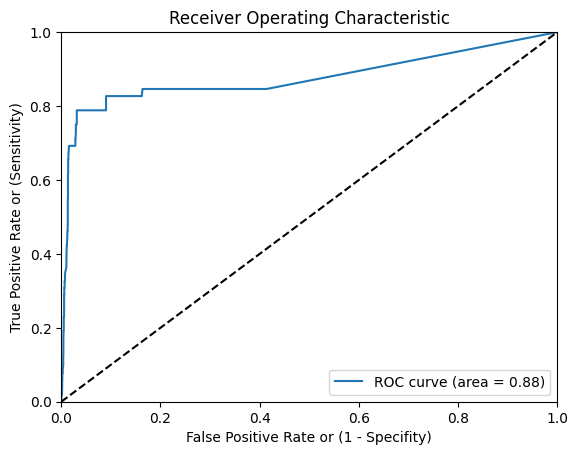

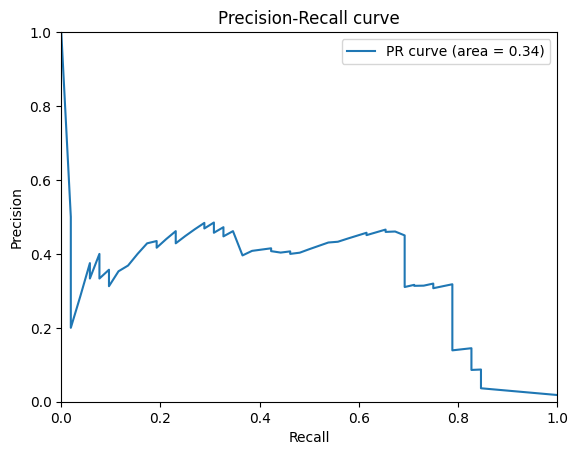

In [154]:
# 4. Evaluate the model in the target data
# Predict the model on the target data
y_probs_validation_Overlapping_model = model_Overlapping_latentSpace.predict_proba(X_target_famd5)[:,1]
y_probs_validation_nonOverlapping_model = model_nonOverlapping_latentSpace.predict_proba(X_target_famd5)[:,1]

# Apply the model to the true overlapping mask and find optimal threshold

true_overlapping_mask = ~same_class_neighbours_target[1]

y_probs_target_all = (true_overlapping_mask * y_probs_validation_Overlapping_model) + ((~true_overlapping_mask) * y_probs_validation_nonOverlapping_model)

optimal_threshold = find_optimal_moving_threshold_from_probas(y_probs=y_probs_target_all, y_test = labels_target, verbose = True)

__, __, __, __, __, __, f1, __ = calculate_performance_metrics_from_probas(y_probs = y_probs_target_all, y_test = labels_target, 
                                                                    threshold= optimal_threshold, print_roc = True, print_pr = True, verbose = True)

In [155]:
# 4.1. Differentiate the performances over non-overlapping and overlapping settings
print('----------')
print('Performance on the NON-overlapping setting')
# y_probs_target_all = (true_overlapping_mask * y_probs_validation_Overlapping_model) + ((~true_overlapping_mask) * y_probs_validation_nonOverlapping_model)
# y_probs_target_nonOverlapping = ((~true_overlapping_mask) * y_probs_validation_nonOverlapping_model)
y_probs_target_nonOverlapping = y_probs_validation_nonOverlapping_model[(~true_overlapping_mask)]
labels_target_nonOverlapping = labels_target[(~true_overlapping_mask)]

optimal_threshold_nonOverlapping = find_optimal_moving_threshold_from_probas(y_probs=y_probs_target_nonOverlapping, y_test = labels_target_nonOverlapping, verbose = True)

__, __, __, __, __, __, f1, __ = calculate_performance_metrics_from_probas(y_probs = y_probs_target_nonOverlapping, y_test = labels_target_nonOverlapping, 
                                                                    threshold= optimal_threshold_nonOverlapping, print_roc = False, print_pr = False, verbose = True)

print('\n----------')
print('Performance on the OVERLAPPING setting')
# y_probs_target_all = (true_overlapping_mask * y_probs_validation_Overlapping_model) + ((~true_overlapping_mask) * y_probs_validation_nonOverlapping_model)
# y_probs_target_all = (true_overlapping_mask * y_probs_validation_Overlapping_model)
y_probs_target_Overlapping = y_probs_validation_nonOverlapping_model[true_overlapping_mask]
labels_target_Overlapping = labels_target[true_overlapping_mask]

optimal_threshold_Overlapping = find_optimal_moving_threshold_from_probas(y_probs=y_probs_target_Overlapping, y_test = labels_target_Overlapping, verbose = True)

__, __, __, __, __, __, f1, __ = calculate_performance_metrics_from_probas(y_probs = y_probs_target_Overlapping, y_test = labels_target_Overlapping, 
                                                                    threshold= optimal_threshold_Overlapping, print_roc = False, print_pr = False, verbose = True)


print('\n----------')
print('Performance on the AGGREGATED setting (with differentiated threshold in each area)')
true_labels_concat = pd.concat([labels_target_nonOverlapping, labels_target_Overlapping], axis = 0)

y_pred_nonOverlapping = pd.Series(['Positive' if p == True else 'Negative' for p in (y_probs_target_nonOverlapping > optimal_threshold_nonOverlapping)])
y_pred_Overlapping = pd.Series(['Positive' if p == True else 'Negative' for p in (y_probs_target_Overlapping > optimal_threshold_Overlapping)])
y_pred_concat = pd.concat([y_pred_nonOverlapping, y_pred_Overlapping], axis = 0)

f1 = f1_score(true_labels_concat, y_pred_concat, pos_label = 'Positive')
recall = recall_score(true_labels_concat, y_pred_concat, pos_label = 'Positive')
precision = precision_score(true_labels_concat, y_pred_concat, pos_label = 'Positive')
roc_curve_auc = roc_auc_score(true_labels_concat, np.concatenate([y_probs_target_nonOverlapping,y_probs_target_Overlapping], axis = 0))

f1, recall, precision,roc_curve_auc

----------
Performance on the NON-overlapping setting
Optimal threshold: 0.06
Optimal f1: 0.06451612903225806


AUC Score: 0.5433857281958548
Precision / Positive predictive value: 0.04081632653061224
Specificity: 0.983001808318264
Recall / sensitivity: 0.15384615384615385
Negative predictive value: 0.9959692194943203
Accuracy: 0.9791216702663786
F-1: 0.06451612903225806
Precision-Recall AUC: 0.009722380608081952

----------
Performance on the OVERLAPPING setting
Optimal threshold: 0.0
Optimal f1: 0.3614457831325301


AUC Score: 0.3943589743589743
Precision / Positive predictive value: 0.3409090909090909
Specificity: 0.42
Recall / sensitivity: 0.38461538461538464
Negative predictive value: 0.4666666666666667
Accuracy: 0.4044943820224719
F-1: 0.3614457831325301
Precision-Recall AUC: 0.38532472862995704

----------
Performance on the AGGREGATED setting (with differentiated threshold in each area)


(0.23448275862068965,
 0.3269230769230769,
 0.1827956989247312,
 0.5012057658150021)

#### Iterative model to find optimal alignment setting

Having validated the earlier model, let us know formalize the better level of alignment in the latent space. The iterative model is as follows:
1. FAMD transform source and target to n_components
2. Compute the distance metric
3. Build and evaluate the model:
- 3.1. Determine overlapping and non-overlapping dictionaries
- 3.2. Train model on source
- 3.3. Test model on target

In [168]:
print(X_target.shape, X_source.shape, labels_target.value_counts(), labels_source.value_counts())

X_combined = pd.concat([X_source, X_target], axis = 0)
y_combined = pd.concat([labels_source, labels_target], axis = 0)
X_combined.shape, y_combined.value_counts()

(2867, 17) (86058, 17) Negative    2815
Positive      52
Name: RSV_test_result, dtype: int64 Negative    83404
Positive     2654
Name: RSV_test_result, dtype: int64


((88925, 17),
 Negative    86219
 Positive     2706
 Name: RSV_test_result, dtype: int64)

In [ ]:
# 0. Compute the Wasserstein-like before start of alignment 
X_source_dummies = pd.get_dummies(X_source)
X_target_dummies = pd.get_dummies(X_target)
distance_before = wasserstein_balltree(X_source_dummies, X_target_dummies)

print(f"Wasserstein-like distance before alignment: {distance_before}")


Wasserstein-like distance at 0 components: 0.930411165203219

Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.05484673127425688
N1 metric for 2 neighbours : 0.08233981733249673
N1 metric for 3 neighbours : 0.10346510492923378
N1 metric for 4 neighbours : 0.1254735178600479
Done!
Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.026159748866410926
N1 metric for 2 neighbours : 0.0435995814440181
N1 metric for 3 neighbours : 0.06278339727938609
N1 metric for 4 neighbours : 0.07673526334147196
Done!
----------------
Building non-overlapping model ...
Training model ... RandomForestClassifier(class_weight={'Negative': 1.007058184301173,
                                     'Positive': 0.43524683500953204},
      

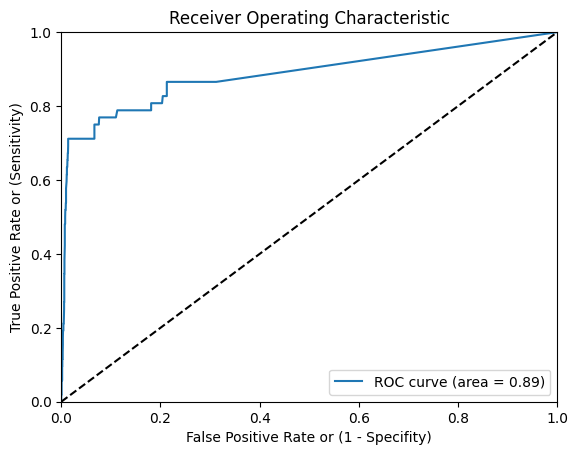

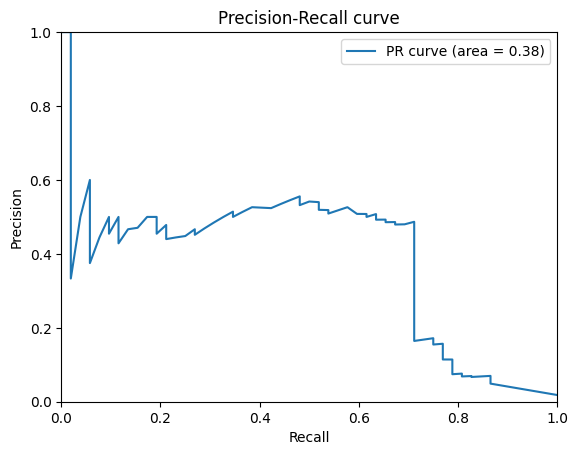


Wasserstein-like distance at 1 components: 0.002871051939925791

Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.057298566083339164
N1 metric for 2 neighbours : 0.08238629761323757
N1 metric for 3 neighbours : 0.1039996281577541
N1 metric for 4 neighbours : 0.13103953147877012
Done!
Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.02720613882106737
N1 metric for 2 neighbours : 0.04569236135333099
N1 metric for 3 neighbours : 0.06103941402162538
N1 metric for 4 neighbours : 0.0777816532961284
Done!
----------------
Building non-overlapping model ...
Training model ... RandomForestClassifier(class_weight={'Negative': 1.005467119672468,
                                     'Positive': 0.5148354629597313},
    

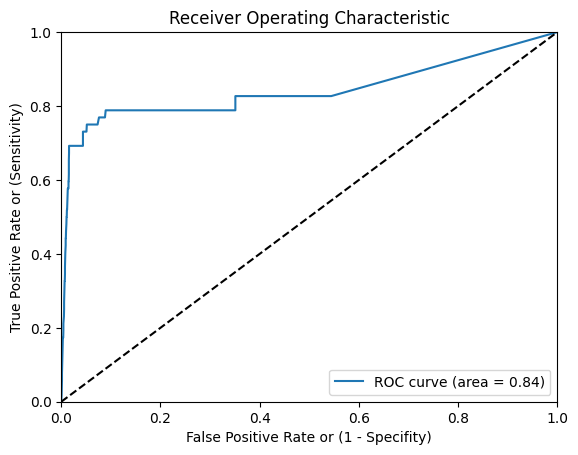

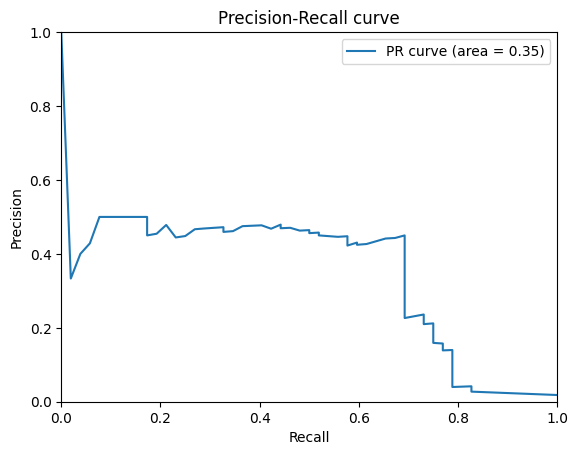


Wasserstein-like distance at 2 components: 0.03228032174888866

Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.0543586883264775
N1 metric for 2 neighbours : 0.08458249087824488
N1 metric for 3 neighbours : 0.1061144809314648
N1 metric for 4 neighbours : 0.13282902228729465
Done!
Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.036623648412975274
N1 metric for 2 neighbours : 0.05441227764213463
N1 metric for 3 neighbours : 0.06766655040111613
N1 metric for 4 neighbours : 0.08336239972096271
Done!
----------------
Building non-overlapping model ...
Training model ... RandomForestClassifier(class_weight={'Negative': 1.0081481839601643,
                                     'Positive': 0.3101490148252601},
    

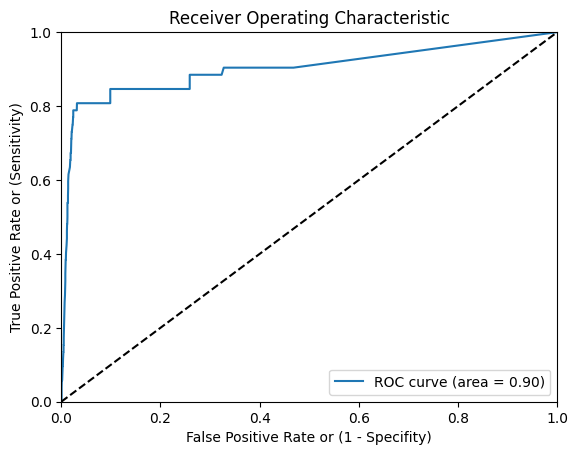

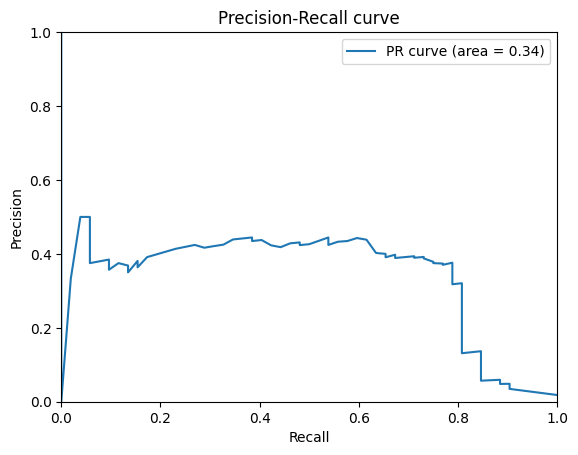


Wasserstein-like distance at 3 components: 0.05420157751667259

Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.05896023611982615
N1 metric for 2 neighbours : 0.08548885635269232
N1 metric for 3 neighbours : 0.10922865974110485
N1 metric for 4 neighbours : 0.1330149434102582
Done!
Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.032089291942797304
N1 metric for 2 neighbours : 0.05162190442971748
N1 metric for 3 neighbours : 0.06662016044645969
N1 metric for 4 neighbours : 0.08126961981164982
Done!
----------------
Building non-overlapping model ...
Training model ... RandomForestClassifier(class_weight={'Negative': 1.0068151675076569,
                                     'Positive': 0.41014541027514},
     

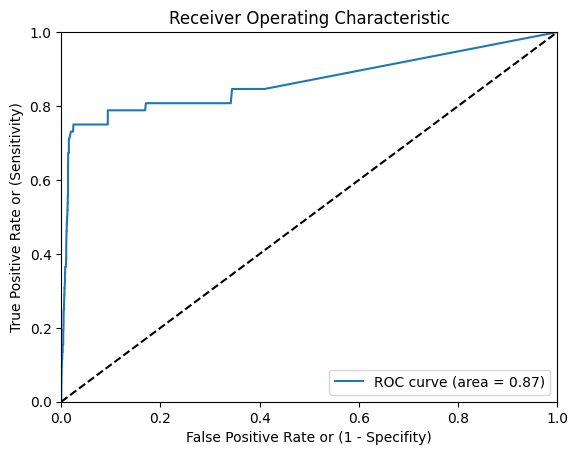

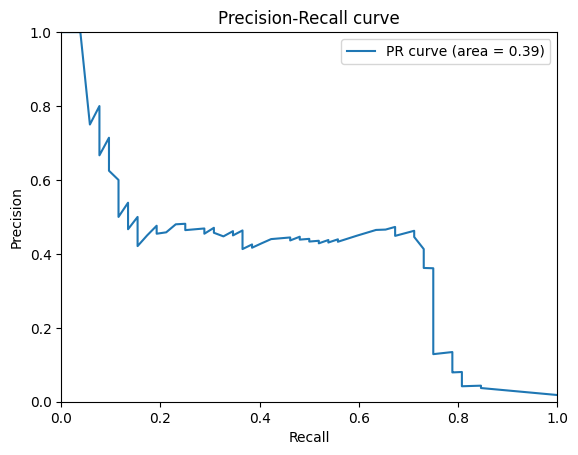


Wasserstein-like distance at 5 components: 0.2231123212678203

Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.05656650166166999
N1 metric for 2 neighbours : 0.08201445536731045
N1 metric for 3 neighbours : 0.10343024471867812
N1 metric for 4 neighbours : 0.12504357526319454
Done!
Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.03104290198814086
N1 metric for 2 neighbours : 0.05092431112661322
N1 metric for 3 neighbours : 0.06662016044645969
N1 metric for 4 neighbours : 0.08126961981164982
Done!
----------------
Building non-overlapping model ...
Training model ... RandomForestClassifier(class_weight={'Negative': 1.0071044515840528,
                                     'Positive': 0.3999355841006404},
    

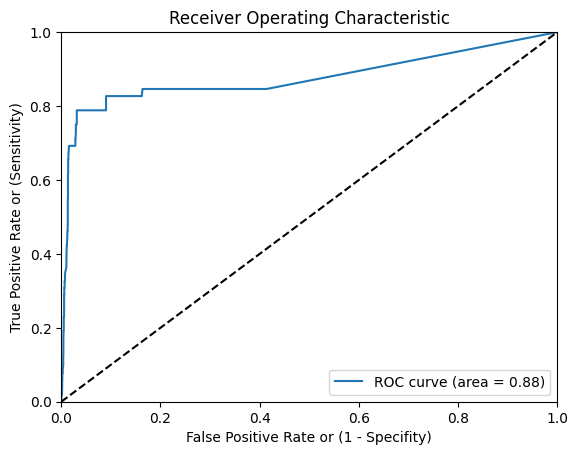

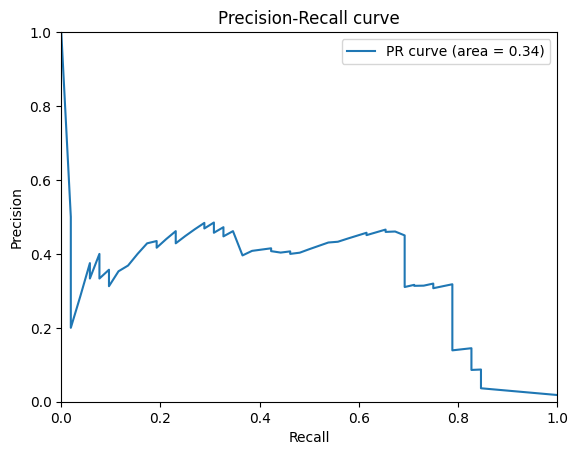


Wasserstein-like distance at 10 components: 0.5378932377613884

Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.056450300959817845
N1 metric for 2 neighbours : 0.0865346626693625
N1 metric for 3 neighbours : 0.10829905412628693
N1 metric for 4 neighbours : 0.1315275744265495
Done!
Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.029647715381932338
N1 metric for 2 neighbours : 0.05231949773282174
N1 metric for 3 neighbours : 0.06871294035577258
N1 metric for 4 neighbours : 0.08022322985699337
Done!
----------------
Building non-overlapping model ...
Training model ... RandomForestClassifier(class_weight={'Negative': 1.0075617815800677,
                                     'Positive': 0.3848268279274326},
   

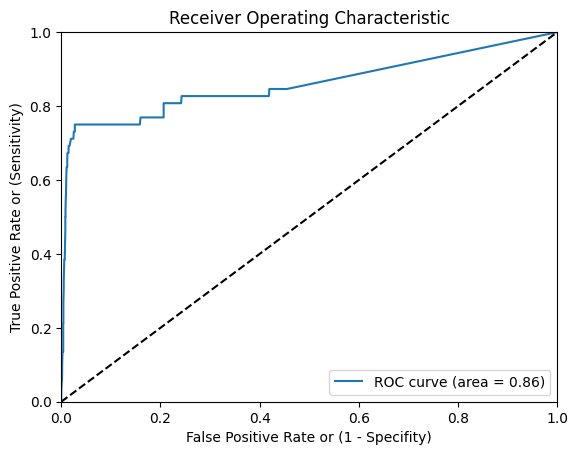

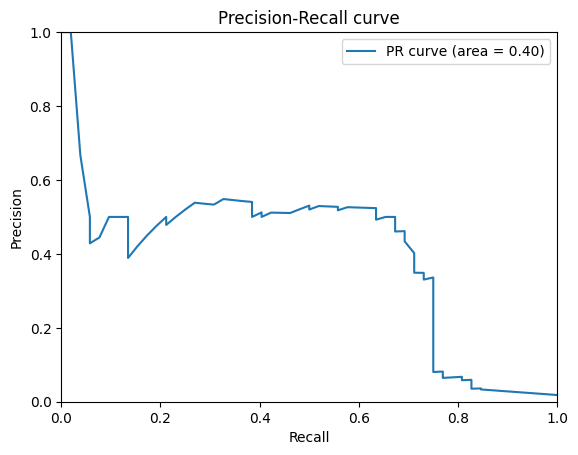


Wasserstein-like distance at 12 components: 0.5430589994128142

Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.05227869576332245
N1 metric for 2 neighbours : 0.0826767993678682
N1 metric for 3 neighbours : 0.10697436612517142
N1 metric for 4 neighbours : 0.13045852796950896
Done!
Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.03174049529124523
N1 metric for 2 neighbours : 0.05545866759679108
N1 metric for 3 neighbours : 0.06836414370422039
N1 metric for 4 neighbours : 0.08092082316009763
Done!
----------------
Building non-overlapping model ...
Training model ... RandomForestClassifier(class_weight={'Negative': 1.0082120489324975,
                                     'Positive': 0.3476928192623161},
    

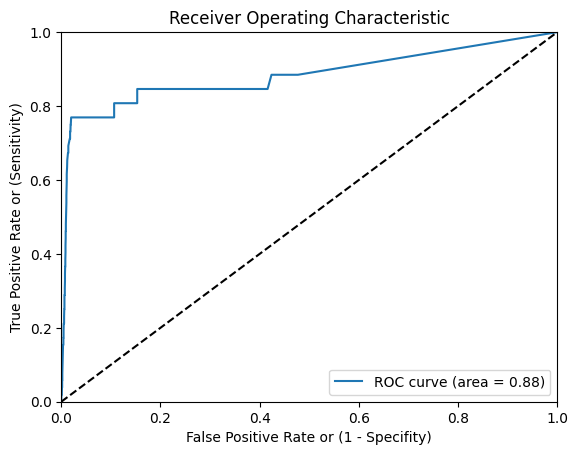

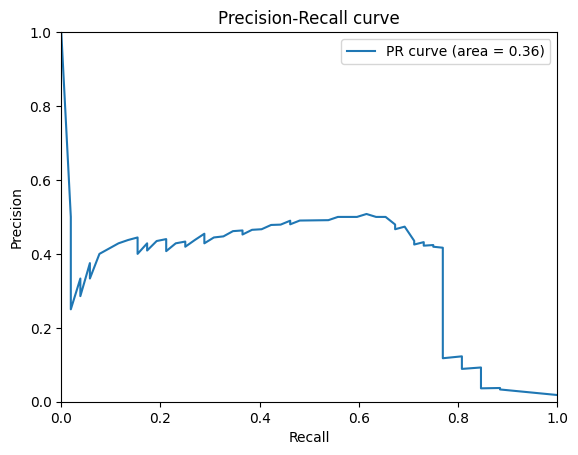


Wasserstein-like distance at 17 components: 0.6597038090380032

Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.0526272978688791
N1 metric for 2 neighbours : 0.08136373143693787
N1 metric for 3 neighbours : 0.10470845243905269
N1 metric for 4 neighbours : 0.12772781147598133
Done!
Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.03104290198814086
N1 metric for 2 neighbours : 0.05510987094523889
N1 metric for 3 neighbours : 0.07045692361353328
N1 metric for 4 neighbours : 0.081618416463202
Done!
----------------
Building non-overlapping model ...
Training model ... RandomForestClassifier(class_weight={'Negative': 1.0071656263252655,
                                     'Positive': 0.4158636539846043},
      

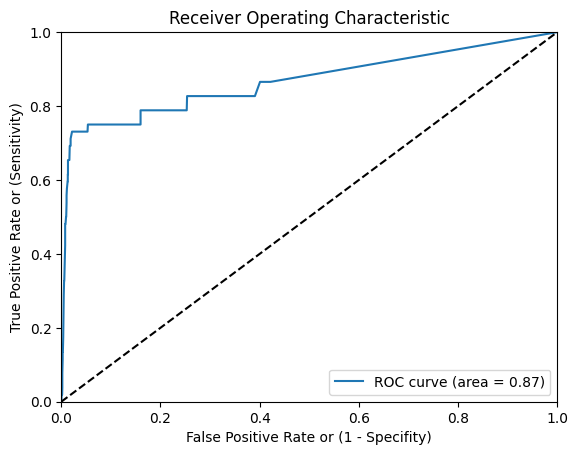

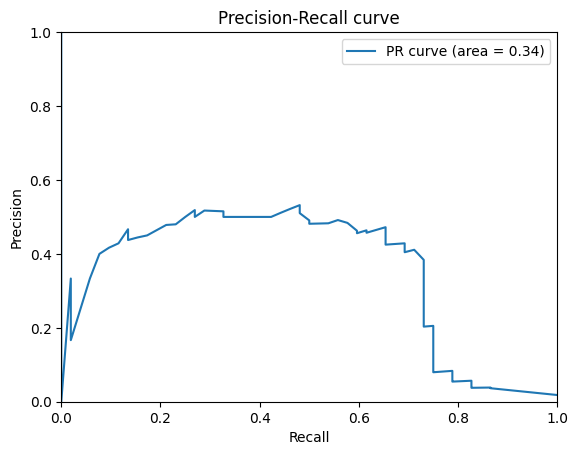

In [169]:
# 1. Alignment in the latent space
n_components_list = [0, 1, 2, 3, 5, 10, 12, X_combined.shape[1]]
distance_metrics = {}
performance_metrics_f1 = {}
performance_metrics_recall = {}
performance_metrics_precision = {}
performance_metrics_rocauc = {}

for n_components in n_components_list:
    random_seed = 42

    # 1. FAMD transform source and target
    if n_components == 0:
        X_combined_famd5 = X_combined.copy()
        X_source_famd5 = pd.get_dummies(X_combined_famd5.iloc[:X_source.shape[0]])
        X_target_famd5 = pd.get_dummies(X_combined_famd5.iloc[-X_target.shape[0]:])

    else:
        famd = prince.FAMD(n_components=n_components, random_state=random_seed)
        famd = famd.fit(X_combined)

        X_combined_famd5 = famd.transform(X_combined)

        X_source_famd5 = X_combined_famd5.iloc[:X_source.shape[0]]
        X_target_famd5 = X_combined_famd5.iloc[-X_target.shape[0]:]


    # 2. Compute the distance metric
    # Compute the Wasserstein-like distance before and after alignment
    distance_Wasserstein = wasserstein_balltree(X_source_famd5, X_target_famd5)

    print(f"\nWasserstein-like distance at {n_components} components: {distance_Wasserstein}\n")
    distance_metrics[n_components] = distance_Wasserstein


    # 3. Build the model
    ## 3.1. Compute the same_neighbours for source and target (and the consequent importance weights)
    same_class_neighbours_source, __, distance_matrix_source, __ = calculate_same_neighbours_and_N1(X = X_source_famd5, y = labels_source, n_neighbours = 5)
    same_class_neighbours_target, __, distance_matrix_target, __ = calculate_same_neighbours_and_N1(X = X_target_famd5, y = labels_target, n_neighbours = 5)


    # Determination of the under-representation of 'Positives' in the target population
    n_neighbours_to_determine_overlap = 1

    overlapping_labels_source = labels_source [same_class_neighbours_source[n_neighbours_to_determine_overlap] == False]
    non_overlapping_labels_source = labels_source [same_class_neighbours_source[n_neighbours_to_determine_overlap] == True]

    overlapping_labels_target = labels_target [same_class_neighbours_target[n_neighbours_to_determine_overlap] == False]
    non_overlapping_labels_target = labels_target [same_class_neighbours_target[n_neighbours_to_determine_overlap] == True]


    # Computation of the importance weights for training of the model on phase 1 data
    P_source_nonOverlapping_negative = non_overlapping_labels_source.value_counts()['Negative'] /(len(non_overlapping_labels_source))
    P_source_nonOverlapping_positive =  non_overlapping_labels_source.value_counts()['Positive'] /(len(non_overlapping_labels_source))

    P_source_Overlapping_negative = overlapping_labels_source.value_counts()['Negative'] /(len(overlapping_labels_source))
    P_source_Overlapping_positive =  overlapping_labels_source.value_counts()['Positive'] /(len(overlapping_labels_source))

    P_target_nonOverlapping_negative = non_overlapping_labels_target.value_counts()['Negative'] /(len(non_overlapping_labels_target))
    P_target_nonOverlapping_positive =  non_overlapping_labels_target.value_counts()['Positive'] /(len(non_overlapping_labels_target))

    P_target_Overlapping_negative = overlapping_labels_target.value_counts()['Negative'] /(len(overlapping_labels_target))
    P_target_Overlapping_positive =  overlapping_labels_target.value_counts()['Positive'] /(len(overlapping_labels_target))

    importance_weights_Overlapping_negative = P_target_Overlapping_negative / P_source_Overlapping_negative
    importance_weights_Overlapping_positive = P_target_Overlapping_positive / P_source_Overlapping_positive
    importance_weights_nonOverlapping_negative = P_target_nonOverlapping_negative / P_source_nonOverlapping_negative
    importance_weights_nonOverlapping_positive = P_target_nonOverlapping_positive / P_source_nonOverlapping_positive


    # 3.2. Train the model on the source data
    aux_same_class_neighbours = same_class_neighbours_source[n_neighbours_to_determine_overlap]

    model_nonOverlapping_latentSpace, model_Overlapping_latentSpace = only_build_2overlapping_models(X = X_source_famd5, labels = labels_source, same_class_neighbors = aux_same_class_neighbours, 
                                                                        random_seed = 42,
                                                                        cost_sensitive_non_overlapping = True, weight_dict_non_overlapping = {'Negative': importance_weights_nonOverlapping_negative, 'Positive': importance_weights_nonOverlapping_positive},
                                                                        cost_sensitive_overlapping = True, weight_dict_overlapping = {'Negative': importance_weights_Overlapping_negative, 'Positive': importance_weights_Overlapping_positive}
                                                                        )

    # 3.3. Evaluate the model on the target data
    y_probs_validation_Overlapping_model = model_Overlapping_latentSpace.predict_proba(X_target_famd5)[:,1]
    y_probs_validation_nonOverlapping_model = model_nonOverlapping_latentSpace.predict_proba(X_target_famd5)[:,1]

    # Apply the model to the true overlapping mask and find optimal threshold

    true_overlapping_mask = ~same_class_neighbours_target[1]

    y_probs_target_all = (true_overlapping_mask * y_probs_validation_Overlapping_model) + ((~true_overlapping_mask) * y_probs_validation_nonOverlapping_model)

    optimal_threshold = find_optimal_moving_threshold_from_probas(y_probs=y_probs_target_all, y_test = labels_target, verbose = True)

    auc_score, precision, recall, __, __, __, f1, __ = calculate_performance_metrics_from_probas(y_probs = y_probs_target_all, y_test = labels_target, 
                                                                    threshold= optimal_threshold, print_roc = True, print_pr = True, verbose = True)


    performance_metrics_f1[n_components] = f1
    performance_metrics_recall[n_components] = recall
    performance_metrics_precision[n_components] = precision
    performance_metrics_rocauc[n_components] = auc_score

Final findings:

- The conjugation of those 3 factors (feature engineering, label shift and share latent space) allows to achieve a good-performing model in the transfer learning from phase 1 to phase 2
- We still need to decide on the 'alignment_factor' (i.e. the number of components in the FAMD latent space) that results optimal. For the sake of interpretability and visualization, I suggest taking n_components = 3.